In [1]:
# Install and load necessary libraries for visualization
if (!requireNamespace("pheatmap", quietly = TRUE)) {
  install.packages("pheatmap")
}
if (!requireNamespace("outliers", quietly = TRUE)) {
  install.packages("outliers")
}
# Install and load the 'entropy' package if not already installed
if (!requireNamespace("entropy", quietly = TRUE)) {
  install.packages("entropy")
}
if (!requireNamespace("anomalize", quietly = TRUE)) {
  install.packages("anomalize")
}
if (!requireNamespace("tidyverse", quietly = TRUE)) {
  install.packages("tidyverse")
}
if (!requireNamespace("dbscan", quietly = TRUE)) {
  install.packages("dbscan")
}
library(dbscan)
library(tidyverse)
library(tibbletime)
library(anomalize)
library(timetk)
library(entropy)
library(pheatmap)
library(ggplot2)
library(gridExtra)
library(tsoutliers)
library(keras)
library(reticulate)


Attaching package: ‘dbscan’


The following object is masked from ‘package:stats’:

    as.dendrogram


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘tibbletime’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘timetk’


The following objects are masked from ‘package:anomalize’:

    anomalize, plot_anomalies



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Registered S3 method overwritten by 'quantmo

In [2]:
# Load the dataset
# Spécifier le nombre de lignes à charger (40%)
n_lines_to_load <- round(0.01 * length(readLines("ar41_for_ulb.csv")))

# Charger 40% des lignes du fichier CSV
data <- read.csv("ar41_for_ulb.csv", nrows = n_lines_to_load)
#data <- read.csv("ar41_for_ulb_mini.csv")

In [3]:
# Data Type Conversion
data_split <- strsplit(as.character(data$X.mapped_veh_id.timestamps_UTC.lat.lon.RS_E_InAirTemp_PC1.RS_E_InAirTemp_PC2.RS_E_OilPress_PC1.RS_E_OilPress_PC2.RS_E_RPM_PC1.RS_E_RPM_PC2.RS_E_WatTemp_PC1.RS_E_WatTemp_PC2.RS_T_OilTemp_PC1.RS_T_OilTemp_PC2), ";")
data_df <- as.data.frame(do.call(rbind, data_split))
colnames(data_df) <- c("X","mapped_veh_id", "timestamps_UTC", "lat", "lon", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")
data_df <- subset(data_df, select = -X)
data_df$mapped_veh_id <- as.factor(data_df$mapped_veh_id)
data_df$timestamps_UTC <- as.POSIXct(data_df$timestamps_UTC, format = "%Y-%m-%d %H:%M:%S")
columns_to_convert <- c("lat", "lon","RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")
for (col in columns_to_convert) {
  data_df[, col] <- as.numeric(gsub(",", ".", data_df[, col]))
}

Warning message in (function (..., deparse.level = 1) :
“number of columns of result is not a multiple of vector length (arg 1591)”


In [4]:
# Check for NA values
na_count <- sum(is.na(data_df))
if (na_count > 0) {
  print(paste("There are", na_count, "NA values in the dataset. Handle them appropriately."))
  
}
# Remove duplicate rows
data_df <- data_df[!duplicated(data_df), ]

[1] "There are 476 NA values in the dataset. Handle them appropriately."


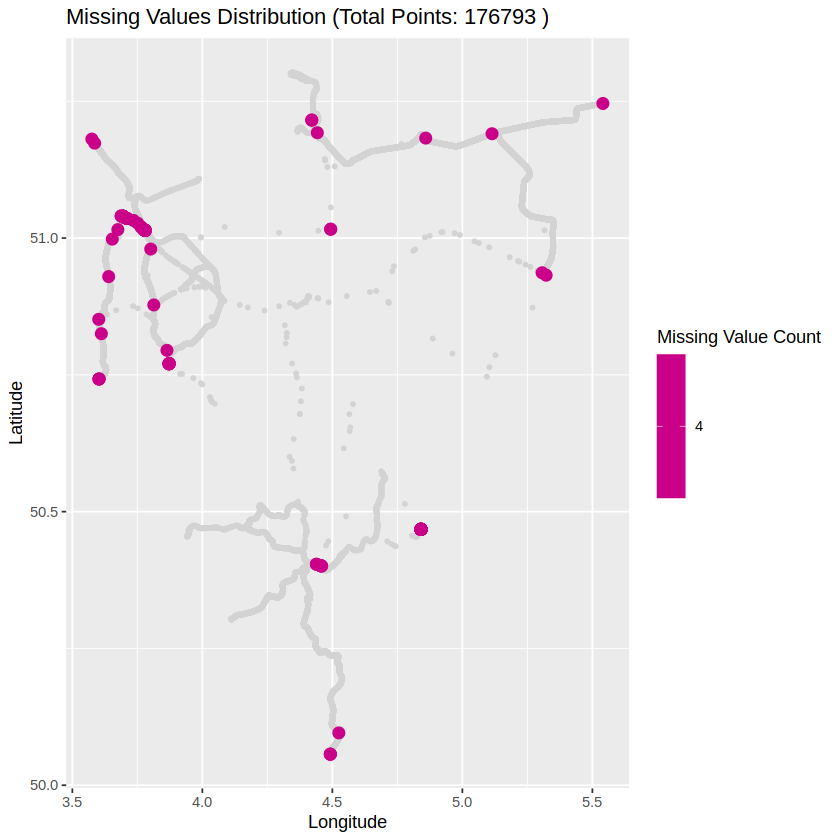

In [5]:
# Check for NA values in any of the specified columns
missing_values <- rowSums(is.na(data_df[, c("RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")]))

# Check if there are any missing values
if (sum(missing_values) > 0) {
  # Create a new data frame for missing values
  missing_data <- data.frame(lon = data_df$lon[missing_values > 0],
                             lat = data_df$lat[missing_values > 0],
                             missing_count = missing_values[missing_values > 0])

  # Create a plot
  ggplot(data_df, aes(x = lon, y = lat)) +
    geom_point(size = 1, color = "lightgray") +
    geom_point(data = missing_data, aes(color = missing_count), size = 3) +
    scale_color_gradient(low = "blue", high = "red") +
    labs(title = paste("Missing Values Distribution (Total Points:", nrow(data_df), ")"),
         x = "Longitude",
         y = "Latitude",
         color = "Missing Value Count")
      # Analyze the distribution of missing values

} else {
  # Create a plot without missing values
  library(ggplot2)
  ggplot(data_df, aes(x = lon, y = lat)) +
    geom_point(size = 1, color = "lightgray") +
    labs(title = paste("Total Points:", nrow(data_df)),
         x = "Longitude",
         y = "Latitude")
}


In [6]:
missing_analysis <- data.frame(feature = colnames(data_df)[7:16], 
                                 missing_count = colSums(is.na(data_df[, c("RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")])))
# Filter features with missing values
missing_analysis_filtered <- missing_analysis[missing_analysis$missing_count > 0, ]

# Print the filtered analysis
if (nrow(missing_analysis_filtered) > 0) {
  print("Analysis of Features with Missing Values:")
  print(missing_analysis_filtered)
} else {
  print("Aucune feature n'a de valeur manquante.")
}


[1] "Analysis of Features with Missing Values:"
                             feature missing_count
RS_E_InAirTemp_PC2 RS_E_OilPress_PC2           119
RS_E_OilPress_PC2       RS_E_RPM_PC2           119
RS_E_RPM_PC2        RS_E_WatTemp_PC2           119
RS_E_WatTemp_PC2    RS_T_OilTemp_PC2           119


In [7]:
# Sélectionner les colonnes pertinentes pour l'imputation
cols_capteur_1 <- c("RS_E_InAirTemp_PC1", "RS_E_OilPress_PC1", "RS_E_RPM_PC1", "RS_E_WatTemp_PC1", "RS_T_OilTemp_PC1")
cols_capteur_2 <- c("RS_E_InAirTemp_PC2", "RS_E_OilPress_PC2", "RS_E_RPM_PC2", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC2")

# Créer un dataframe pour l'imputation
impute_data <- data_df[, c(cols_capteur_1, cols_capteur_2)]

# Imputation des valeurs manquantes des capteurs 2 en utilisant les capteurs 1
for (col in cols_capteur_2) {
  impute_data[[col]][is.na(impute_data[[col]])] <- impute_data[[sub("_PC2", "_PC1", col)]][is.na(impute_data[[col]])]
}

# Créer une copie de data_df avec les valeurs manquantes imputées
data_df_impute <- data_df
data_df_impute[, cols_capteur_2] <- impute_data[, cols_capteur_2]

In [8]:
# Assuming data_df_WNA is your dataframe without NA values

# Detect and handle outliers using the IQR method
handle_outliers <- function(column) {
  Q1 <- quantile(column, 0.25)
  Q3 <- quantile(column, 0.75)
  IQR_value <- Q3 - Q1
  lower_limit <- Q1 - 1.5 * IQR_value
  upper_limit <- Q3 + 1.5 * IQR_value
  column[column < lower_limit] <- lower_limit
  column[column > upper_limit] <- upper_limit
  return(column)
}

# Apply outlier handling to relevant numeric columns
columns_to_handle_outliers <- c("lat", "lon", "RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1", "RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")


for (col in columns_to_handle_outliers) {
  data_df_impute[, col] <- handle_outliers(data_df_impute[, col])
}

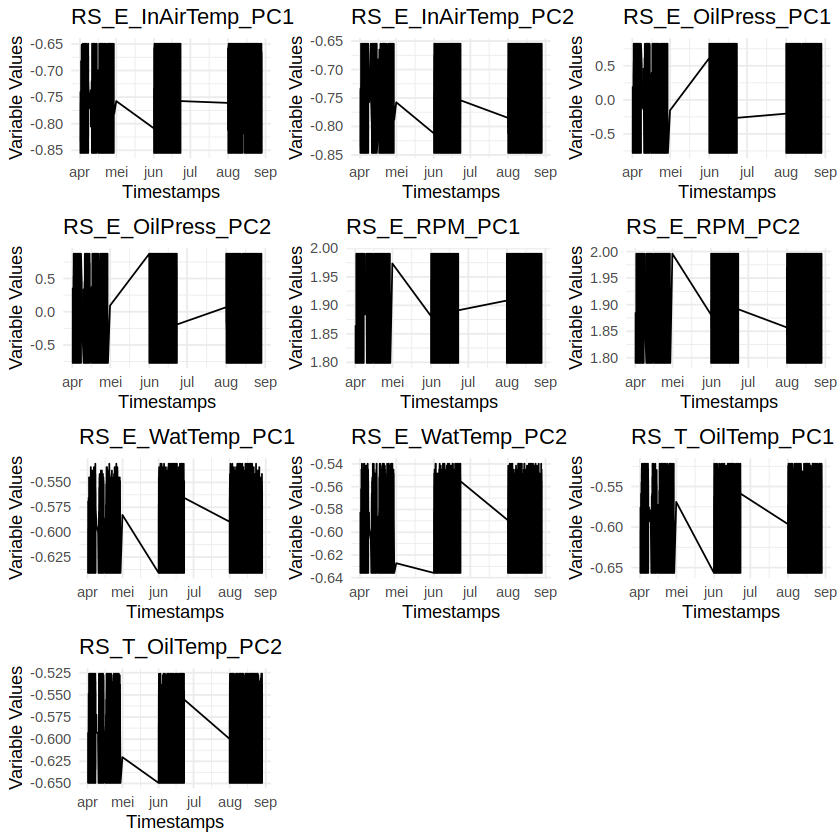

In [9]:
# Subset the data for selected variables
selected_vars <- c("RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1","RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")

# Subset the data
subset_data <- data_df_impute[c("timestamps_UTC", selected_vars)]

# Melt the data for easier plotting
melted_data <- reshape2::melt(subset_data, id.vars = "timestamps_UTC")

# Normalize the data
melted_data$value <- scale(melted_data$value)

# Create a separate plot for each variable
plots_list <- lapply(selected_vars, function(var) {
  ggplot(melted_data[melted_data$variable == var, ], aes(x = timestamps_UTC, y = value)) +
    geom_line() +
    labs(title = paste(var),
         x = "Timestamps",
         y = "Variable Values") +
    theme_minimal()
})

grid.arrange(grobs = plots_list)  # Adjust ncol as needed


In [10]:
# Check for NA values
na_count <- sum(is.na(data_df))

if (na_count > 0) {
  print(paste("There are", na_count, "NA values in the dataset. Removing them."))

  # Remove rows with NA values
  data_df_WNA <- na.omit(data_df)
}else {

  # Now, your data doesn't contain NA values, and you can proceed with further analysis or visualization.
  data_df_WNA <- data_df
}

for (col in columns_to_handle_outliers) {
  data_df_WNA[, col] <- handle_outliers(data_df_WNA[, col])
}


[1] "There are 476 NA values in the dataset. Removing them."


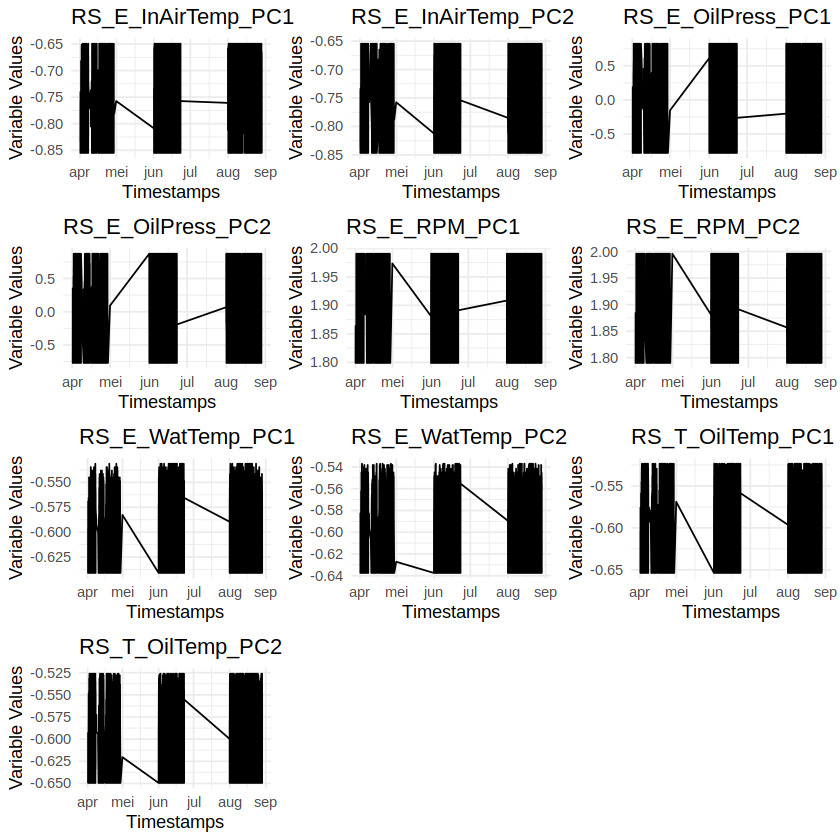

In [11]:
# Now, your data doesn't contain NA values, and you can proceed with further analysis or visualization.
# Subset the data for selected variables
selected_vars <- c("RS_E_InAirTemp_PC1", "RS_E_InAirTemp_PC2", "RS_E_OilPress_PC1","RS_E_OilPress_PC2", "RS_E_RPM_PC1", "RS_E_RPM_PC2", "RS_E_WatTemp_PC1", "RS_E_WatTemp_PC2", "RS_T_OilTemp_PC1", "RS_T_OilTemp_PC2")

# Subset the data
subset_data <- data_df_WNA[c("timestamps_UTC", selected_vars)]

# Melt the data for easier plotting
melted_data <- reshape2::melt(subset_data, id.vars = "timestamps_UTC")

# Normalize the data
melted_data$value <- scale(melted_data$value)

# Create a separate plot for each variable
plots_list <- lapply(selected_vars, function(var) {
  ggplot(melted_data[melted_data$variable == var, ], aes(x = timestamps_UTC, y = value)) +
    geom_line() +
    labs(title = paste(var),
         x = "Timestamps",
         y = "Variable Values") +
    theme_minimal()
})

grid.arrange(grobs = plots_list)  # Adjust ncol as needed


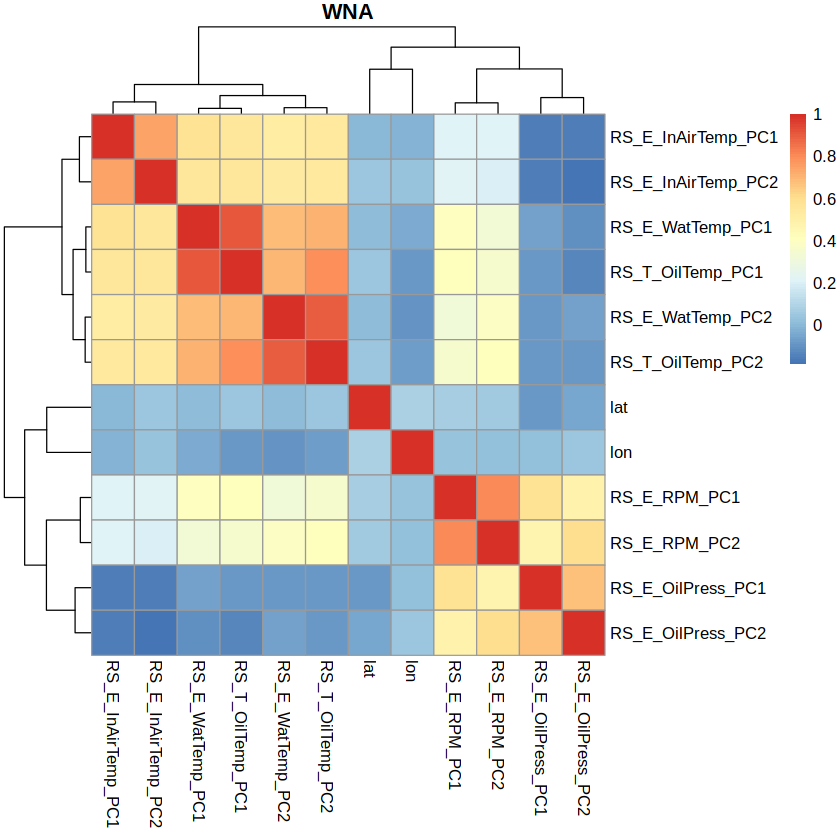

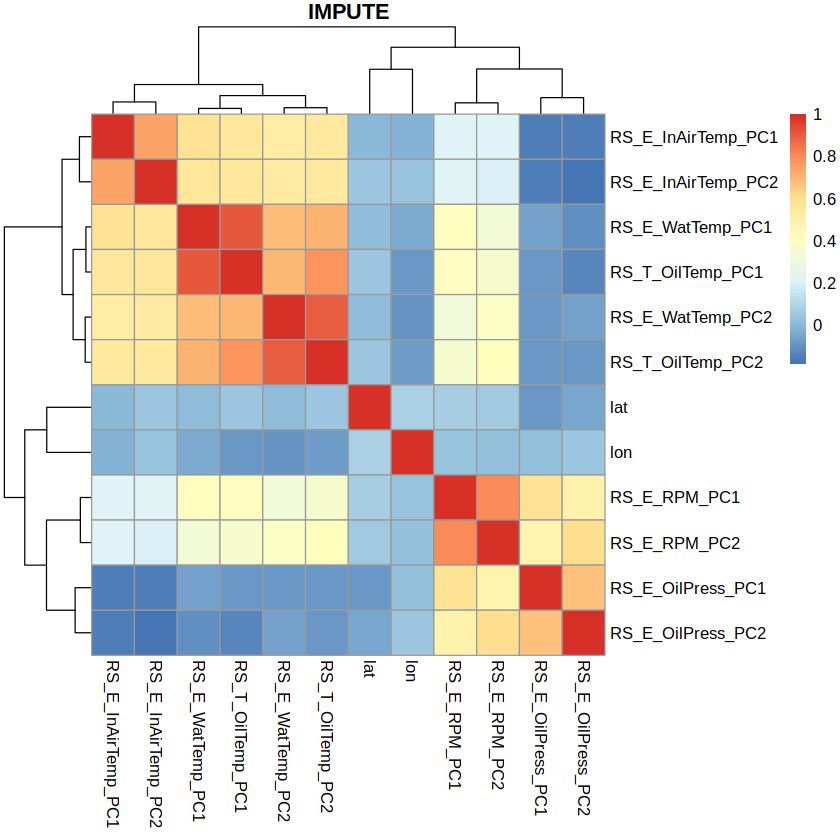

In [12]:
# Normaliser les valeurs
normalized_data <- scale(data_df_WNA[, columns_to_handle_outliers])
normalized_data2 <- scale(data_df_impute[, columns_to_handle_outliers])

# Étudier la corrélation entre les variables
correlation_matrix <- cor(normalized_data)
correlation_matrix2 <- cor(normalized_data2)

# Fonction pour créer une heatmap avec pheatmap
create_heatmap <- function(correlation_matrix, title) {
  pheatmap(correlation_matrix, main = title)
}

# Mise en page des graphiques côte à côte
layout(matrix(c(1, 2), nrow = 1, byrow = TRUE), widths = c(1, 1))

# Créer les deux heatmaps
heatmap1 <- create_heatmap(correlation_matrix, "WNA")
heatmap2 <- create_heatmap(correlation_matrix2, "IMPUTE")


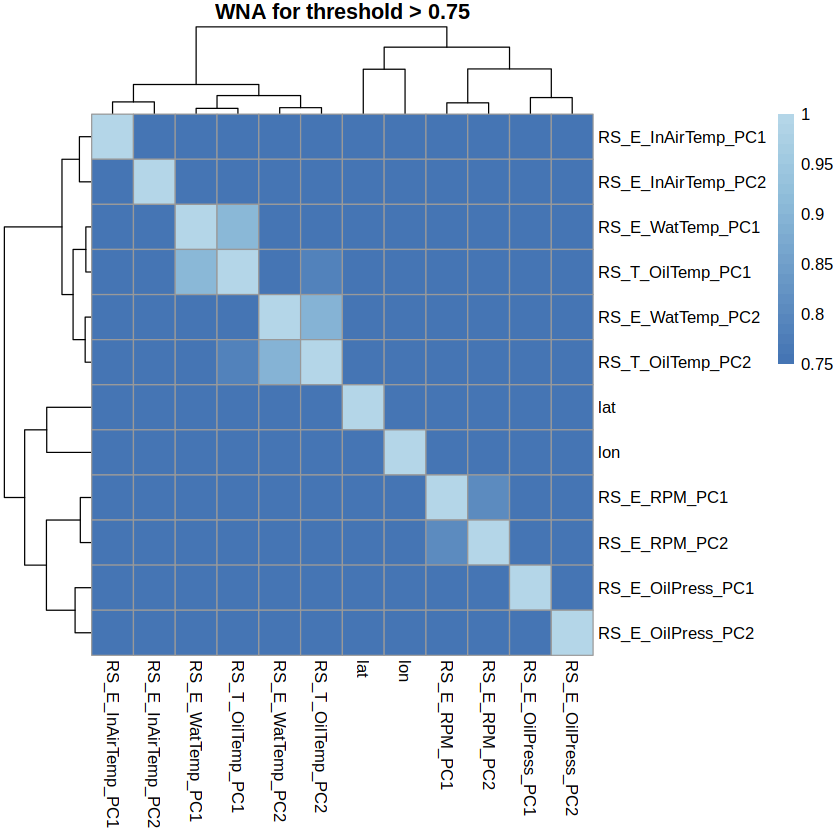

In [13]:
# Seuil pour filtrer les valeurs
threshold <- 0.75

# Fonction pour créer une heatmap avec pheatmap (en utilisant les breaks)
create_thresholded_heatmap <- function(correlation_matrix, title, threshold) {
  pheatmap(correlation_matrix, main = title, breaks = seq(threshold, 1, by = 0.01))
}

# Mise en page des graphiques côte à côte
layout(matrix(c(1, 2), nrow = 1, byrow = TRUE), widths = c(1, 1))

# Créer les deux heatmaps avec seuillage
heatmap1 <- create_thresholded_heatmap(correlation_matrix, "WNA for threshold > 0.75", threshold)
#heatmap2 <- create_thresholded_heatmap(correlation_matrix2, "IMPUTE", threshold)


In [14]:
head(data_df_WNA,5)

,mapped_veh_id,timestamps_UTC,lat,lon,RS_E_InAirTemp_PC1,RS_E_InAirTemp_PC2,RS_E_OilPress_PC1,RS_E_OilPress_PC2,RS_E_RPM_PC1,RS_E_RPM_PC2,RS_E_WatTemp_PC1,RS_E_WatTemp_PC2,RS_T_OilTemp_PC1,RS_T_OilTemp_PC2
,<fct>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,181.0,2023-08-01 03:44:12,50.76982,3.872114,27,23,255,238,794,801,83,81,76,77
2,143.0,2023-08-01 06:36:29,51.03999,3.693429,33,32,272,324,802,804,78,78,73,74
3,183.0,2023-08-24 06:53:54,50.74220,3.602035,31,33,234,182,799,802,82,82,85,87
4,177.0,2023-08-01 13:53:38,50.93091,5.327132,35,38,220,244,794,801,77,81,78,82
5,143.0,2023-08-24 07:02:30,51.18077,3.575259,41,34,227,282,806,800,85,78,82,79


In [15]:
library(tidyverse)
library(tibbletime)
library(anomalize)
library(timetk)

In [16]:
anomalize <- anomalize::anomalize
plot_anomalies <- anomalize::plot_anomalies

frequency = 100 seconds

trend = 1182 seconds



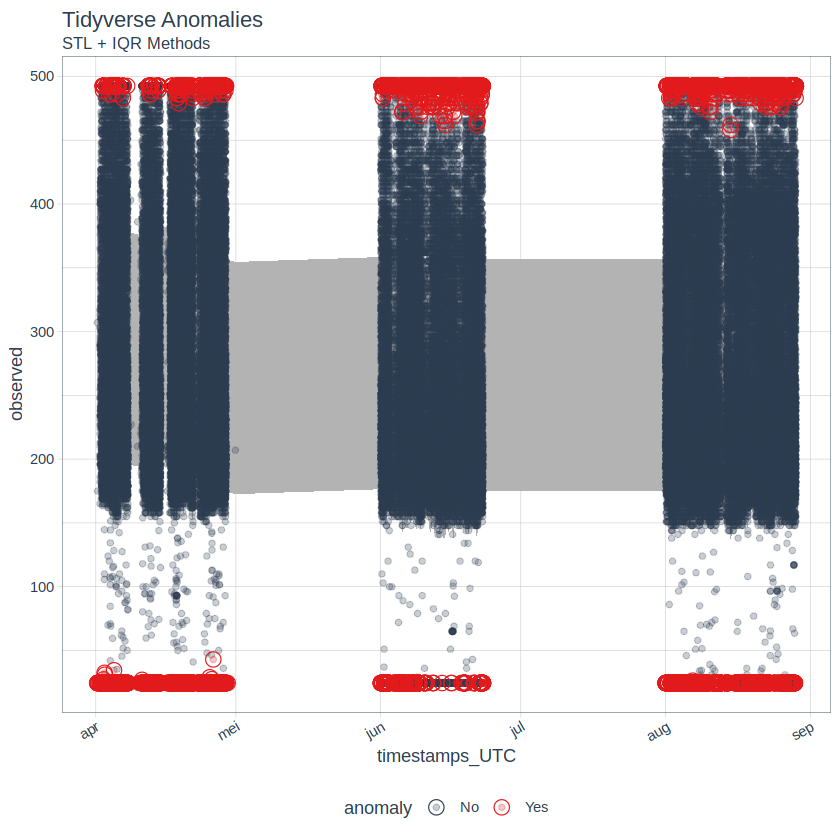

In [17]:
data_df_WNA %>%
  # Selecting relevant columns
  select(-mapped_veh_id, timestamps_UTC, everything()) %>%
  
  # Converting to tbl_time
  as_tbl_time(index = timestamps_UTC) %>%
  
  # Arranging data by timestamps
  arrange(timestamps_UTC) %>%
  
  # Time series decomposition using STL method
  time_decompose(RS_E_OilPress_PC1, method = "stl") %>%
  
  # Anomaly detection using IQR method on the remainder
  anomalize(remainder, alpha = 0.50, max_anoms = 0.05, method = "iqr") %>%
  
  # Recompose the time series
  time_recompose() %>%
  
  # Anomaly Visualization
  plot_anomalies(time_recomposed = TRUE, ncol = 3, alpha_dots = 0.25) +
  
  labs(title = "Tidyverse Anomalies", subtitle = "STL + IQR Methods")

frequency = 100 seconds

trend = 1182 seconds



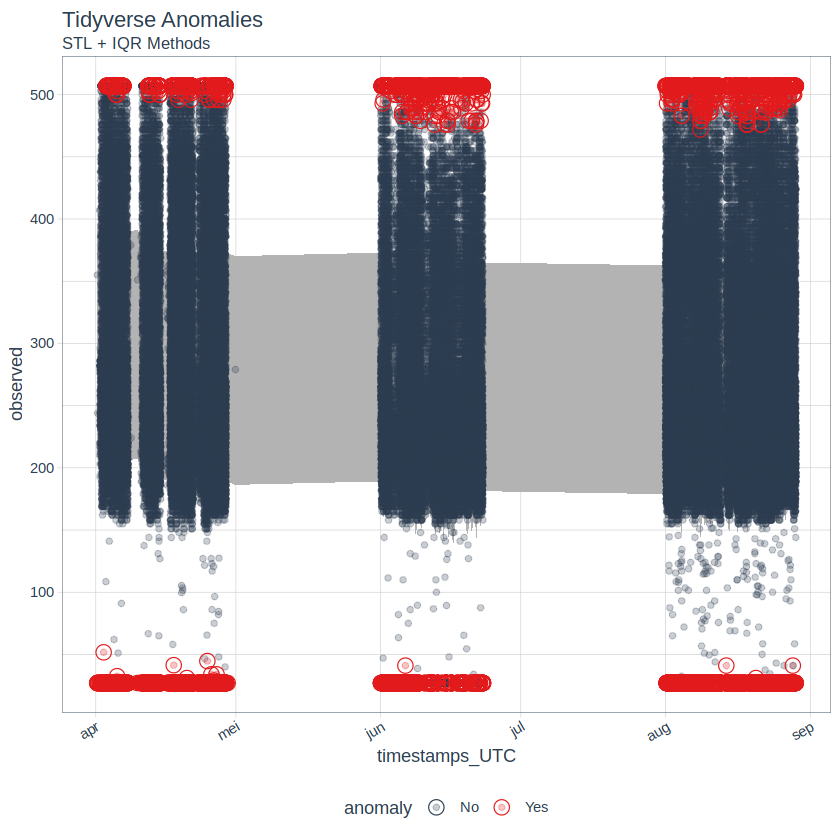

In [18]:
data_df_WNA %>%
  # Selecting relevant columns
  select(-mapped_veh_id, timestamps_UTC, everything()) %>%
  
  # Converting to tbl_time
  as_tbl_time(index = timestamps_UTC) %>%
  
  # Arranging data by timestamps
  arrange(timestamps_UTC) %>%
  
  # Time series decomposition using STL method
  time_decompose(RS_E_OilPress_PC2, method = "stl") %>%
  
  # Anomaly detection using IQR method on the remainder
  anomalize(remainder, alpha = 0.50, max_anoms = 0.05, method = "iqr") %>%
  
  # Recompose the time series
  time_recompose() %>%
  
  # Anomaly Visualization
  plot_anomalies(time_recomposed = TRUE, ncol = 3, alpha_dots = 0.25) +
  
  labs(title = "Tidyverse Anomalies", subtitle = "STL + IQR Methods")

In [19]:
library(plotly)

# Sélectionnez les noms des variables pour lesquelles vous souhaitez appliquer le processus
variables_to_analyze <- c("RS_E_OilPress_PC1", "RS_E_OilPress_PC2")

# Initialisez une liste pour stocker les graphiques
plots_list <- list()

# Créez une boucle pour appliquer le processus à chaque variable
for (variable in variables_to_analyze) {
  # Appliquez le processus d'analyse
  plot <- data_df_WNA %>%
    select(-c(lat, lon, mapped_veh_id), timestamps_UTC, everything()) %>%
    as_tbl_time(index = timestamps_UTC) %>%
    arrange(timestamps_UTC) %>%
    time_decompose({{ variable }}, method = "stl") %>%
    anomalize(remainder, alpha = 0.50, max_anoms = 0.05, method = "iqr") %>%
    time_recompose() %>%
    plot_anomalies(time_recomposed = TRUE, alpha_dots = 0.25) +
    labs(title = paste("Tidyverse Anomalies for", variable), subtitle = "STL + IQR Methods")
  
  # Ajoutez le graphique à la liste
  plots_list[[variable]] <- plot
}


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


frequency = 100 seconds

trend = 1182 seconds

frequency = 100 seconds

trend = 1182 seconds



In [ ]:
# Combinez les graphiques dans une disposition en subplot
subplot(plots_list[[1]], plots_list[[2]], nrows = 2)